# What's My Flight Status?: Using Flight Data to Predict Flight Delays
***
Author: Andre Layton
***

## Overview

One of the most common applications of supervised learning in the aviation industry is predicting flight delays. By analyzing historical data on flight delays, machine learning and deep learning algorithms can identify patterns and factors that correlate with delays. This information can then be used to predict if a particular flight is likely to be delayed. Carriers can use these predictions to take preemptive measures, such as adjusting schedules or re-routing passengers, in order to minimize the impact of delays.

## Business Problem

I’ve been hired to create an algorithm that can predict flight delays, which will eventually be deployed as an app for consumers to be able to track their flights. This is beneficial to both the airline and potential passengers – for the airline, it will help with flight logistics and reduce fees due to delays (i.e. tarmac fees, reimbursements, etc.). For passengers, the app will allow them to make delay arrangements and take measures ahead of time, and possibly save on delay expenses. While delays are frustrating whether expected or not, United aims to use this strategy to display company honesty and gain more control over their flights.

>Note: The ultimate objective is to develop an app for consumer use, but within the constraints of this analysis, the model will be saved and stored in the repository [here.](/best_model.h5)

<img src="https://res.cloudinary.com/sagacity/image/upload/c_crop,h_2799,w_4199,x_0,y_0/c_limit,dpr_auto,f_auto,fl_lossy,q_80,w_1080/shutterstock_402702424_dlgrgk.jpg" style="height:650px" />

## Data Understanding 

To start, I import all the necessary packages, and I set a seed for reproducibility purposes. Then, I begin loading the data, which is split into two files - a text file (`.txt`) and a CSV file (`.csv`). The text file contains the metadata, which in this case contains various column names and a short description. The CSV file contains the flight data needed for analysis.

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

from imblearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report,\
                            ConfusionMatrixDisplay, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers, optimizers

# Create a seed for reproducibility
seed=24

In [2]:
# Load the metadata (column descriptions)
metadata = open("data/raw_data_documentation.txt", "r")
print(metadata.read())

AIRPORT_COORDINATES
	ORIGIN_AIRPORT_ID: 	Airport ID, matches to ORIGIN_AIRPORT_ID in other files
	DISPLAY_AIRPORT_NAME:  	Display Airport, matches to DISPLAY_AIRPORT_NAME in other files
	LATITUDE: 		Latitude for airport
	LONGITUDE: 		Longitude for airport

B43_AIRCRAFT_INVENTORY
	MANUFACTURE_YEAR: 	Manufacture year
	TAIL_NUM: 		Unique tail number, matches to TAIL_NUM in other files
	NUMBER_OF_SEATS: 	Number of seats on aircraft
	
CARRIER_DECODE
	AIRLINE_ID: 		Airport ID, matches to AIRLINE_ID in other files
	OP_UNIQUE_CARRIER: 	Carrier code, matches to OP_UNIQUE_CARRIER in other files
	CARRIER_NAME: 		Carrier name, matches to UNIQUE_CARRIER_NAME or CARRIER_NAME in other files

ONTIME_REPORTING_XX
	MONTH: 			Month
	DAY_OF_MONTH: 		Day of the month (1-31)
	DAY_OF_WEEK: 		Day of the week
	OP_UNIQUE_CARRIER: 	Carrier code, matches to OP_UNIQUE_CARRIER in other files
	TAIL_NUM: 		Unique tail number, matches to TAIL_NUM in other files
	OP_CARRIER_FL_NUM: 	Flight number
	ORIGIN_AIRPORT_ID: 	A

In [3]:
# Load the flight data
data = pd.read_csv('data/full_data_flightdelay.csv')

# Preview the first 10 records
data.head(10)

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,1,7,0,0800-0859,2,1,25,143,Southwest Airlines Co.,13056,...,8,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
1,1,7,0,0700-0759,7,1,29,191,Delta Air Lines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
2,1,7,0,0600-0659,7,1,27,199,Delta Air Lines Inc.,13056,...,18,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
3,1,7,0,0600-0659,9,1,27,180,Delta Air Lines Inc.,13056,...,2,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
4,1,7,0,0001-0559,7,1,10,182,Spirit Air Lines,13056,...,1,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
5,1,7,0,0001-0559,3,1,10,180,Frontier Airlines Inc.,13056,...,5,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
6,1,7,0,0700-0759,6,1,29,186,Frontier Airlines Inc.,13056,...,2,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
7,1,7,1,0001-0559,7,1,10,186,Frontier Airlines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
8,1,7,0,0001-0559,7,1,10,180,Frontier Airlines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
9,1,7,0,0600-0659,8,1,27,186,Frontier Airlines Inc.,13056,...,1,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91


The dataframe above gives me an initial look into the dataset, but I will apply a few more methods to gain a better understanding (i.e. `info()`, `isna()`, etc.). These techniques will help me learn more about my data, including the existence of any missing values and the data types of the columns. 

In [4]:
# Print column information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6489062 entries, 0 to 6489061
Data columns (total 26 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   MONTH                          int64  
 1   DAY_OF_WEEK                    int64  
 2   DEP_DEL15                      int64  
 3   DEP_TIME_BLK                   object 
 4   DISTANCE_GROUP                 int64  
 5   SEGMENT_NUMBER                 int64  
 6   CONCURRENT_FLIGHTS             int64  
 7   NUMBER_OF_SEATS                int64  
 8   CARRIER_NAME                   object 
 9   AIRPORT_FLIGHTS_MONTH          int64  
 10  AIRLINE_FLIGHTS_MONTH          int64  
 11  AIRLINE_AIRPORT_FLIGHTS_MONTH  int64  
 12  AVG_MONTHLY_PASS_AIRPORT       int64  
 13  AVG_MONTHLY_PASS_AIRLINE       int64  
 14  FLT_ATTENDANTS_PER_PASS        float64
 15  GROUND_SERV_PER_PASS           float64
 16  PLANE_AGE                      int64  
 17  DEPARTING_AIRPORT              object 
 18  LA

Initially, I can see the method above displays the data type for each feature. Another point is the amount of data present. There are over 6.4 million observations, which will need to be reduced considering I'm only interested in United Airlines flights. The method below filters out the records based on the airline, revealing there are over 600,000 observations that will be analyzed to build my algorithm. 

In [5]:
# Print airline information
data['CARRIER_NAME'].value_counts()

Southwest Airlines Co.          1296329
Delta Air Lines Inc.             938346
American Airlines Inc.           903640
United Air Lines Inc.            601044
SkyWest Airlines Inc.            584204
Midwest Airline, Inc.            300154
JetBlue Airways                  269596
Alaska Airlines Inc.             239337
American Eagle Airlines Inc.     228792
Comair Inc.                      219324
Endeavor Air Inc.                203827
Spirit Air Lines                 189419
Mesa Airlines Inc.               177600
Frontier Airlines Inc.           120872
Atlantic Southeast Airlines       99044
Hawaiian Airlines Inc.            74898
Allegiant Air                     42636
Name: CARRIER_NAME, dtype: int64

The first method also gives me an idea into whether there are any missing values in the dataset. To know for sure, I will apply some more methods that will take the sum of every missing value in each column and returns those values. I find that, fortunately, there are no missing values present in my data, which will make cleaning the data more straightforward.

In [6]:
# Find the amount of missing values in each column
data.isna().sum()

MONTH                            0
DAY_OF_WEEK                      0
DEP_DEL15                        0
DEP_TIME_BLK                     0
DISTANCE_GROUP                   0
SEGMENT_NUMBER                   0
CONCURRENT_FLIGHTS               0
NUMBER_OF_SEATS                  0
CARRIER_NAME                     0
AIRPORT_FLIGHTS_MONTH            0
AIRLINE_FLIGHTS_MONTH            0
AIRLINE_AIRPORT_FLIGHTS_MONTH    0
AVG_MONTHLY_PASS_AIRPORT         0
AVG_MONTHLY_PASS_AIRLINE         0
FLT_ATTENDANTS_PER_PASS          0
GROUND_SERV_PER_PASS             0
PLANE_AGE                        0
DEPARTING_AIRPORT                0
LATITUDE                         0
LONGITUDE                        0
PREVIOUS_AIRPORT                 0
PRCP                             0
SNOW                             0
SNWD                             0
TMAX                             0
AWND                             0
dtype: int64

## Data Preparation
Now that I've gotten an initial look, it's time to begin preparing the data for modeling. I will start by making a copy of the original dataset, then filtering the data to keep only flights taken with United Airlines. From my earlier observations, I can see that will greatly reduce the data to a little over 600,000 records from 6 million. 

In [7]:
# Make a copy of the dataset
data2 = data.copy()

In [8]:
# Filter United Airlines's records and list the first 10
data2 = data2.loc[data2['CARRIER_NAME'] == 'United Air Lines Inc.']
data2.head(10)

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
21,1,7,0,0800-0859,2,1,25,173,United Air Lines Inc.,13056,...,6,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
22,1,7,0,0800-0859,3,1,25,142,United Air Lines Inc.,13056,...,22,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
23,1,7,0,0900-0959,7,1,28,154,United Air Lines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
24,1,7,1,1000-1059,3,1,29,142,United Air Lines Inc.,13056,...,19,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
25,1,7,0,0600-0659,7,1,27,173,United Air Lines Inc.,13056,...,4,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
26,1,7,0,0700-0759,1,1,29,154,United Air Lines Inc.,13056,...,21,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
27,1,7,0,0600-0659,2,1,27,154,United Air Lines Inc.,13056,...,20,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
28,1,7,0,0600-0659,9,1,27,173,United Air Lines Inc.,13056,...,11,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
29,1,7,0,0001-0559,5,1,10,154,United Air Lines Inc.,13056,...,3,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91
30,1,7,0,0600-0659,3,1,27,173,United Air Lines Inc.,13056,...,4,McCarran International,36.08,-115.152,NONE,0.0,0.0,0.0,65.0,2.91


Next step is to remove all the columns I believe are unnecessary or irrelevant to my model. This will reduce my dimensions from 26 to 12, which includes my target column.

In [9]:
# Drop unnecessary columns and display column information 
cols_to_drop = ['SEGMENT_NUMBER', 'NUMBER_OF_SEATS', 'FLT_ATTENDANTS_PER_PASS', 'AVG_MONTHLY_PASS_AIRPORT', 
                'GROUND_SERV_PER_PASS', 'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'PREVIOUS_AIRPORT', 'AVG_MONTHLY_PASS_AIRLINE',
                'LATITUDE', 'LONGITUDE', 'CARRIER_NAME', 'CONCURRENT_FLIGHTS', 'AIRPORT_FLIGHTS_MONTH', 'AIRLINE_FLIGHTS_MONTH']
data2 = data2.drop(cols_to_drop, axis=1)
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 601044 entries, 21 to 6489030
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   MONTH              601044 non-null  int64  
 1   DAY_OF_WEEK        601044 non-null  int64  
 2   DEP_DEL15          601044 non-null  int64  
 3   DEP_TIME_BLK       601044 non-null  object 
 4   DISTANCE_GROUP     601044 non-null  int64  
 5   PLANE_AGE          601044 non-null  int64  
 6   DEPARTING_AIRPORT  601044 non-null  object 
 7   PRCP               601044 non-null  float64
 8   SNOW               601044 non-null  float64
 9   SNWD               601044 non-null  float64
 10  TMAX               601044 non-null  float64
 11  AWND               601044 non-null  float64
dtypes: float64(5), int64(5), object(2)
memory usage: 59.6+ MB


Now that the columns have been reduced, I will look to do the same with the rows by dropping any duplicates that exist in my dataset. I will also rename some of the column names for easier comprehension, moving forward, and then shift the target column to the end of my dataframe.

In [10]:
data2.duplicated().sum()

18105

In [11]:
data2.drop_duplicates(inplace=True)

In [12]:
# Rename the columns for easier comprehension & list the first 5 records
new_col_names = {'DEP_DEL15': 'DELAYED',
                'PRCP': 'PRECIPITATION',
                'SNWD': 'SNOW_ON_GROUND',
                'TMAX': 'MAX_TEMP_FOR_DAY',
                'AWND': 'MAX_WIND_FOR_DAY'}
data2 = data2.rename(new_col_names, axis=1)
data2.head()

,MONTH,DAY_OF_WEEK,DELAYED,DEP_TIME_BLK,DISTANCE_GROUP,PLANE_AGE,DEPARTING_AIRPORT,PRECIPITATION,SNOW,SNOW_ON_GROUND,MAX_TEMP_FOR_DAY,MAX_WIND_FOR_DAY
21,1,7,0,0800-0859,2,6,McCarran International,0.0,0.0,0.0,65.0,2.91
22,1,7,0,0800-0859,3,22,McCarran International,0.0,0.0,0.0,65.0,2.91
23,1,7,0,0900-0959,7,3,McCarran International,0.0,0.0,0.0,65.0,2.91
24,1,7,1,1000-1059,3,19,McCarran International,0.0,0.0,0.0,65.0,2.91
25,1,7,0,0600-0659,7,4,McCarran International,0.0,0.0,0.0,65.0,2.91


In [13]:
# Shift the target column to the end 
cols_at_end = ['DELAYED']
data2 = data2[[col for col in data2 if col not in cols_at_end] 
        + [col for col in cols_at_end if col in data2]]

# Preview the first 5 records to confirm the change
data2.head()

,MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,PLANE_AGE,DEPARTING_AIRPORT,PRECIPITATION,SNOW,SNOW_ON_GROUND,MAX_TEMP_FOR_DAY,MAX_WIND_FOR_DAY,DELAYED
21,1,7,0800-0859,2,6,McCarran International,0.0,0.0,0.0,65.0,2.91,0
22,1,7,0800-0859,3,22,McCarran International,0.0,0.0,0.0,65.0,2.91,0
23,1,7,0900-0959,7,3,McCarran International,0.0,0.0,0.0,65.0,2.91,0
24,1,7,1000-1059,3,19,McCarran International,0.0,0.0,0.0,65.0,2.91,1
25,1,7,0600-0659,7,4,McCarran International,0.0,0.0,0.0,65.0,2.91,0


By shifting the target column (`'DELAYED'`) to the end of the dataframe, reading the following correlation matrix becomes more straightforward. The correlation matrix displays the Pearson coefficient to communicate how closely correlated each feature is with the others.

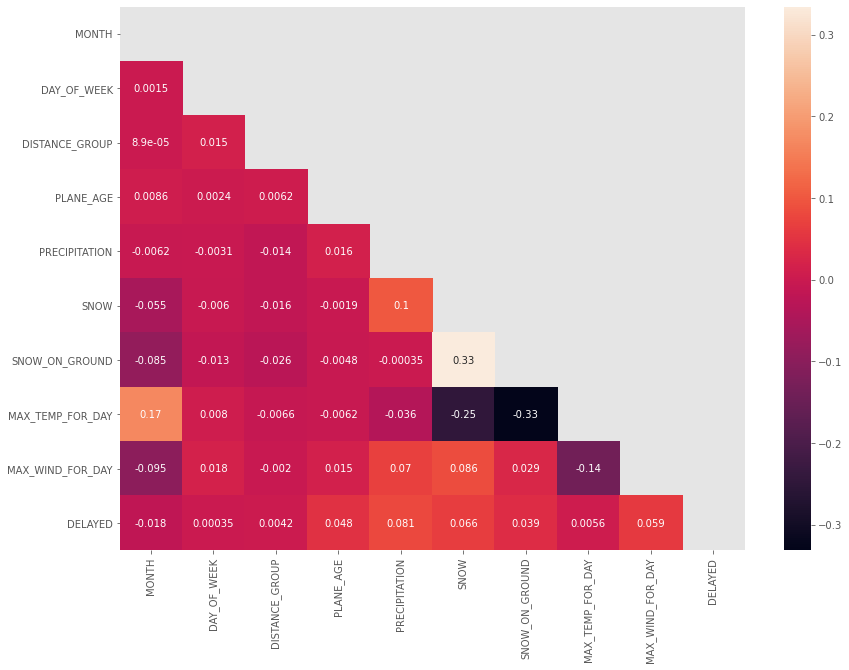

In [14]:
# Plot a heatmap with the Pearson coefficient values listed
fig, ax = plt.subplots(figsize=(14, 10))
mask = np.triu(np.ones_like(data2.corr(), dtype=bool))
sns.heatmap(data2.corr(), mask=mask, annot=True);

The correlation matrix above suggests that precipitation, snow, and the maximum wind speed for the day are the three predictors that correlate strongly with the target variable. This is logical, as weather would come to mind among the biggest reasons for flight delays. However, given that none of the Pearson coefficient values exceed 0.1, that isn't saying much. The day of the week seems to have the weakest correlation, which also makes sense, since delays are more random and tough to define within those time units. Month, however, is a measure of time that negatively correlates with delay status, and may be interesting to take a further look at. 

Now that the dataset has been cleaned up, I want to take a look at the distributions of both the features and the target. This will give me an idea of whether a class imbalance exists (which I suspect there does), and how the feature data is distributed within that imbalance. I'll start by getting a count of the records, based on the `'MONTH'` and `'DAY_OF_WEEK'` features. I plot these value counts, but I divide them based on the target variable - labeling the bars as `'Not Delayed'` or `'Delayed'`.

In [15]:
# Break down the records by month
data2['MONTH'].value_counts().sort_index()

1     43189
2     40457
3     49824
4     49038
5     51038
6     50529
7     52122
8     52538
9     47786
10    51477
11    46880
12    48061
Name: MONTH, dtype: int64

In [16]:
# Break down the records by days of the week
data2['DAY_OF_WEEK'].value_counts().sort_index()

1    86421
2    85043
3    84471
4    84973
5    86153
6    73156
7    82722
Name: DAY_OF_WEEK, dtype: int64

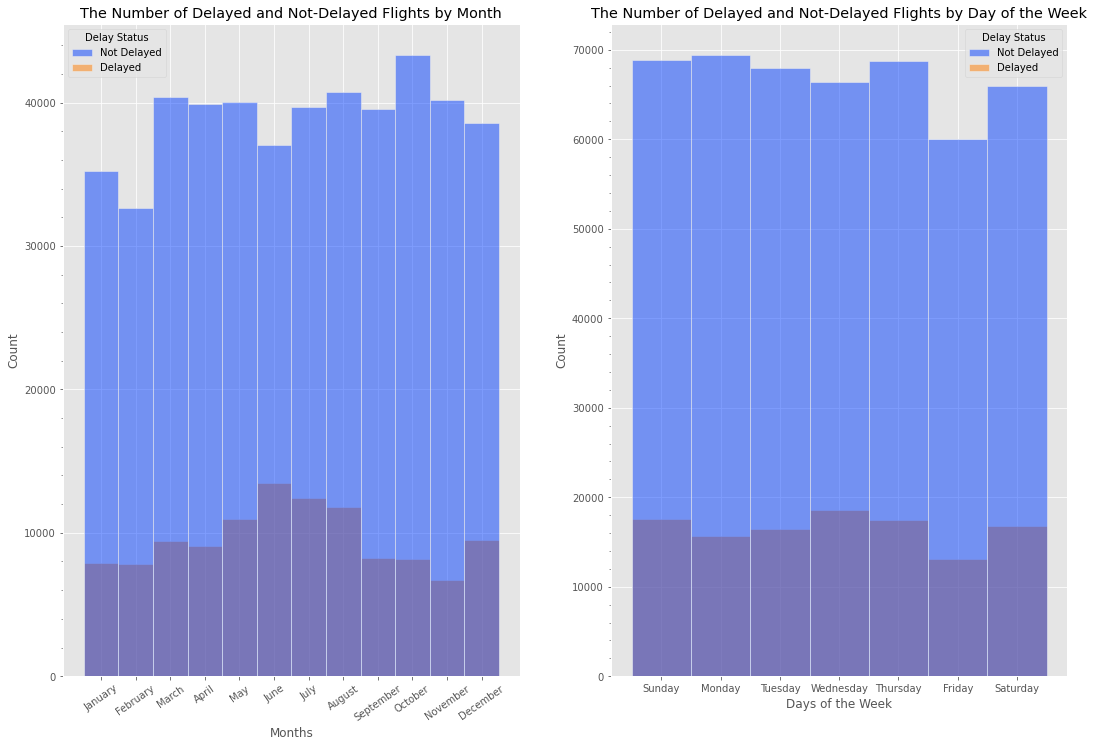

In [17]:
# Plot feature distributions

# Create month and days list objects
months = ['January', 'February', 'March', 'April', 'May', 'June',
         'July', 'August', 'September', 'October', 'November', 'December']
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Visualize the delay status by month
fig, ax = plt.subplots(1, 2, figsize=(18, 12))
plot1 = sns.histplot(data2, x='MONTH', hue='DELAYED', ax=ax[0], palette='bright', discrete=True)

# Change the legend labels
new_title = 'Delay Status'
plot1.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot1.legend_.texts, new_labels):
    t.set_text(l)
    
# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[0].yaxis.set_minor_locator(minor_locator)
ax[0].set_axisbelow(True)
plt.grid(which='both')
ax[0].tick_params(which="both", bottom=True)

# Change x-tick labels to months (written form) and rotate the labels
old_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ax[0].set_xticks(old_labels)
ax[0].set_xticklabels(months)
ax[0].tick_params(axis='x', labelrotation=35)
ax[0].set_xlabel("Months")
ax[0].set_title("The Number of Delayed and Not-Delayed Flights by Month")
    
# Visualize the delay status by days of the week    
plot2 = sns.histplot(data2, x='DAY_OF_WEEK', hue='DELAYED', ax=ax[1], palette='bright', discrete=True)

# Change the legend labels
new_title = 'Delay Status'
plot2.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot2.legend_.texts, new_labels):
    t.set_text(l)

# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[1].yaxis.set_minor_locator(minor_locator)
ax[1].set_axisbelow(True)
plt.grid(which='both')

# Change x-tick labels to days (written form)
old_labels = [1, 2, 3, 4, 5, 6, 7]
ax[1].set_xticks(old_labels)
ax[1].set_xticklabels(days)
ax[1].set_xlabel("Days of the Week")
ax[1].set_title("The Number of Delayed and Not-Delayed Flights by Day of the Week");

Based on the visuals above, I see that there definitely exists a class imbalance in the dataset. In regard to the features, the first plot suggests that the summer months tend to see the highest number of delays, while the colder months seem to see less. In the second plot, the delays are highest on Wednesdays; although, the data seems to have low variation between the days of the week. 

The next few features are the `'DEP_TIME_BLK'` and the `'DISTANCE_GROUP'` columns. The first feature lists the time blocks for United Airlines flights, ranging from midnight (`'0001'`) to 11:59pm, and separated into hour blocks (besides the first block). The second feature lists all 11 distance groups, where the first group travels the shortest distance, and the eleventh group travels the farthest. 

In [18]:
# Break down the records by departure time blocks
data2['DEP_TIME_BLK'].value_counts().sort_index()

0001-0559    10189
0600-0659    42020
0700-0759    47223
0800-0859    42906
0900-0959    36314
1000-1059    35549
1100-1159    34927
1200-1259    35124
1300-1359    28503
1400-1459    33245
1500-1559    30224
1600-1659    35246
1700-1759    35880
1800-1859    36416
1900-1959    33797
2000-2059    21716
2100-2159    19542
2200-2259    12919
2300-2359    11199
Name: DEP_TIME_BLK, dtype: int64

In [19]:
# Break down the records by distance group
data2['DISTANCE_GROUP'].value_counts().sort_index()

1      29818
2      66963
3      80728
4     112096
5      65293
6      46784
7      60650
8      23843
9      16293
10     50679
11     29792
Name: DISTANCE_GROUP, dtype: int64

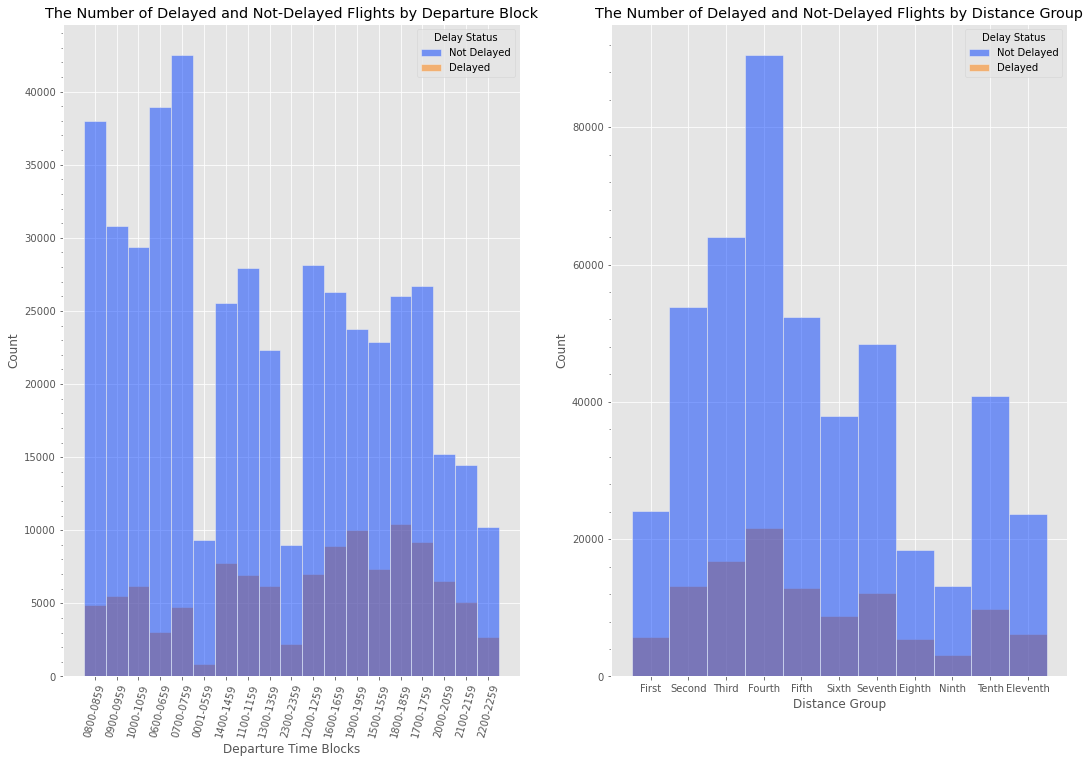

In [20]:
# Plot feature distributions
fig, ax = plt.subplots(1, 2, figsize=(18, 12))

# Visualize the delay status by departure time block
plot3 = sns.histplot(data2, x='DEP_TIME_BLK', hue='DELAYED', ax=ax[0], palette='bright', discrete=True)

# Change legend labels
new_title = 'Delay Status'
plot3.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot3.legend_.texts, new_labels):
    t.set_text(l)

# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[0].yaxis.set_minor_locator(minor_locator)
ax[0].set_axisbelow(True)
plt.grid(which='both')

# Rotate x-tick labels
ax[0].tick_params(axis='x', labelrotation=75)
ax[0].tick_params(which="both", bottom=True)
ax[0].set_xlabel("Departure Time Blocks")
ax[0].set_title("The Number of Delayed and Not-Delayed Flights by Departure Block")
    
# Visualize the delay status by distance group  
plot4 = sns.histplot(data2, x='DISTANCE_GROUP', hue='DELAYED', ax=ax[1], palette='bright', discrete=True)

# Change legend labels
new_title = 'Delay Status'
plot4.legend_.set_title(new_title)
new_labels = ['Not Delayed', 'Delayed']
for t, l in zip(plot4.legend_.texts, new_labels):
    t.set_text(l)
    
# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax[1].yaxis.set_minor_locator(minor_locator)
ax[1].set_axisbelow(True)
plt.grid(which='both')

# Change x-tick labels to distance group (written form)
num_xlabels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
str_xlabels = ['First', 'Second', 'Third', 'Fourth', 'Fifth', 'Sixth', 'Seventh', 'Eighth', 'Ninth', 'Tenth', 'Eleventh']
ax[1].set_xticks(num_xlabels)
ax[1].set_xticklabels(str_xlabels)
ax[1].set_xlabel("Distance Group")
ax[1].set_title("The Number of Delayed and Not-Delayed Flights by Distance Group");

From what I see, the later time blocks (i.e., starting at 4pm to about 8pm) face the most delays. However, in the second visual, the third and fourth distance groups experience more delays, which is far less than those in higher distance groups. 

To be able to plot the rest of the features, I use both kdeplots and boxplots because the data within those columns are numerical and continuous in nature. I see that all six graphs contain outliers that affect the distribution one way or another, as well. 

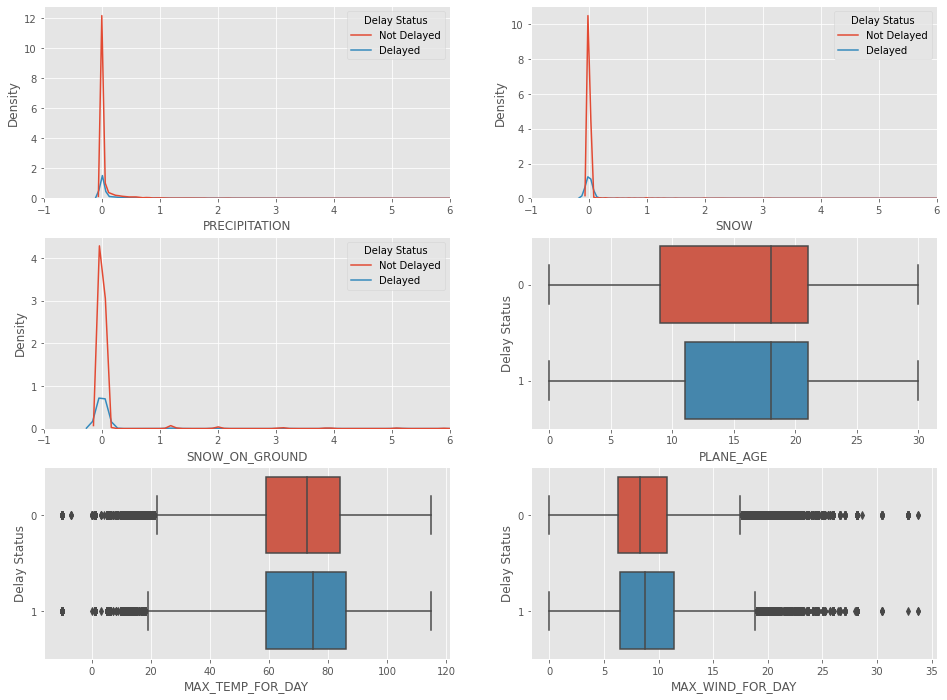

In [21]:
# Plot the remaining continuous variables with the delay status 
fig, ax = plt.subplots(3, 2, figsize=(16, 12))
kde1 = sns.kdeplot(data=data2, x="PRECIPITATION", hue="DELAYED", ax=ax[0,0])
kde2 = sns.kdeplot(data=data2, x="SNOW", hue="DELAYED", ax=ax[0,1])
kde3 = sns.kdeplot(data=data2, x="SNOW_ON_GROUND", hue="DELAYED", ax=ax[1,0])
box1 = sns.boxplot(data=data2, x="PLANE_AGE", y="DELAYED", orient='h', ax=ax[1,1])
box2 = sns.boxplot(data=data2, x="MAX_TEMP_FOR_DAY", y="DELAYED", orient='h', ax=ax[2,0])
box3 = sns.boxplot(data=data2, x="MAX_WIND_FOR_DAY", y="DELAYED", orient='h', ax=ax[2,1]);

# Change the legend in the kdeplots for better comprehension
kdeplots = [kde1, kde2, kde3]
for plot in kdeplots:
    new_title = 'Delay Status'
    plot.legend_.set_title(new_title)
    new_labels = ['Not Delayed', 'Delayed']
    for t, l in zip(plot.legend_.texts, new_labels):
        t.set_text(l)
    plot.set_xlim(-1, 6) 

# Change the y-axis label for the boxplots
boxplots = [box1, box2, box3]
for boxplot in boxplots:
    boxplot.set(ylabel='Delay Status')

It's time to examine the target, and confirm the class imbalance I mentioned earlier. First, I will plot my target as a bar plot, then as a pie chart. I plot both to show both the count and weight of each label in the dataset. 

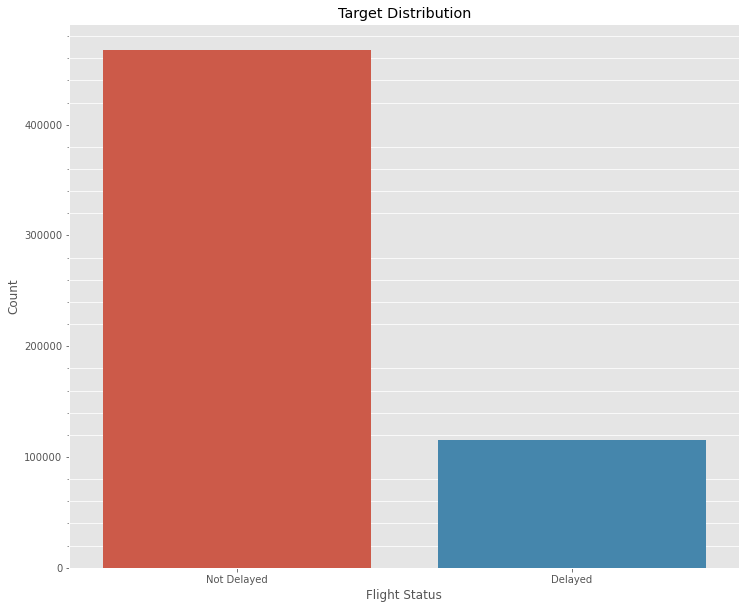

In [22]:
# Visualize the class (target) distribution
fig, ax = plt.subplots(figsize=(12,10))

# Add minor gridlines
minor_locator = AutoMinorLocator(5)
ax.yaxis.set_minor_locator(minor_locator)
ax.set_axisbelow(True)
plt.grid(which='both')

# Plot the target 
sns.countplot(data=data2, x='DELAYED', orient='v')
ax.set_title('Target Distribution')

# Change x-tick labels and axis labels
old_labels = [0, 1]
new_xlabels = ['Not Delayed', 'Delayed']
ax.set_xticks(old_labels)
ax.set_xticklabels(new_xlabels)
ax.set_xlabel("Flight Status")
ax.set_ylabel("Count");

The bar plot above further confirms my earlier speculation of a class imbalance - showing over 460,000 flights as `'Not Delayed'` and a little under 120,000 as `'Delayed'` flights. The pie plot below reinforces this observation, but with weights. I see that out of 600,000 flights, about 20% are delayed - this is quite high considering the high amount of flights taken in a year through United. 

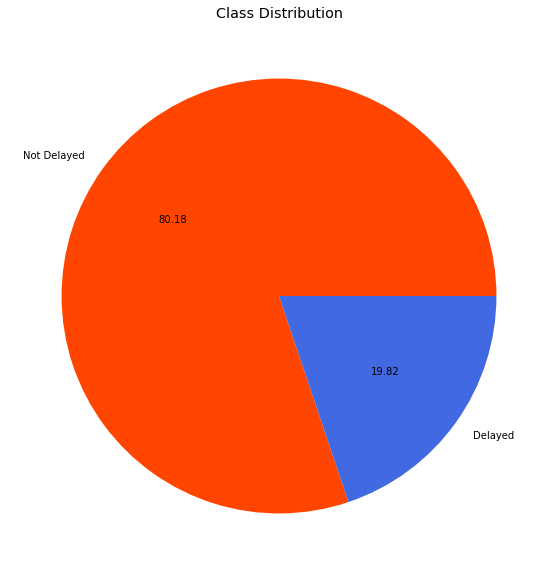

In [23]:
# Create a pie plot to further visualize the class distribution
fig, ax = plt.subplots(figsize=(12, 10))
data2['DELAYED'].value_counts().plot.pie(autopct='%.2f', title='Class Distribution', 
                                        labels=['Not Delayed', 'Delayed'], colors=['orangered', 'royalblue'])
ax.yaxis.set_visible(False);

I feel I've gained sufficient insight into how my data is structured and distributed; so, now it's time to begin modeling and building my algorithm. 

### Further Preprocessing:
In order to properly model my dataframe, I need to encode the categorical features into quanitative data. I use pandas's `get_dummies` function to encode my five categorical columns into multiple, numerical columns; then list the first 5 records to confirm the transformation. 

In [24]:
# Encode categorical features
cols_to_encode = ['MONTH', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'DISTANCE_GROUP', 'DEPARTING_AIRPORT']
data2_enc = pd.get_dummies(data2, columns=cols_to_encode)

In [25]:
# List the first five records to confirm the transformation
data2_enc.head()

,PLANE_AGE,PRECIPITATION,SNOW,SNOW_ON_GROUND,MAX_TEMP_FOR_DAY,MAX_WIND_FOR_DAY,DELAYED,MONTH_1,MONTH_2,MONTH_3,...,DEPARTING_AIRPORT_Standiford Field,DEPARTING_AIRPORT_Stapleton International,DEPARTING_AIRPORT_Syracuse Hancock International,DEPARTING_AIRPORT_Tampa International,DEPARTING_AIRPORT_Theodore Francis Green State,DEPARTING_AIRPORT_Truax Field,DEPARTING_AIRPORT_Tucson International,DEPARTING_AIRPORT_Tulsa International,DEPARTING_AIRPORT_Washington Dulles International,DEPARTING_AIRPORT_Will Rogers World
21,6,0.0,0.0,0.0,65.0,2.91,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
22,22,0.0,0.0,0.0,65.0,2.91,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
23,3,0.0,0.0,0.0,65.0,2.91,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
24,19,0.0,0.0,0.0,65.0,2.91,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
25,4,0.0,0.0,0.0,65.0,2.91,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


The dataset above will serve as my final dataframe, but I will also divide it into a training, testing and validation set. I will split the data 75/25, with 25% of the dataset reserved for the test set, and a seed set for reproducibility. Now, I will split the test data even further (by half, actually) into a smaller test set and a newly-formed validation set to iterate through my modeling process. I check the shape multiple times to be sure the data stays intact. 

In [26]:
# Split the dataset into training and testing sets
y = data2_enc['DELAYED']
X = data2_enc.drop('DELAYED', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=seed)
X_train.shape

(437204, 139)

In [27]:
# Split the test dataset in half to create a validation dataset
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=seed)
X_val.shape

(72868, 139)

Given the initial class imbalance, I need to apply a sampling technique - specifically, undersampling - to reduce the majority class (`'Not Delayed'`) in my data to an even ratio with the minority class (`'Delayed'`). I plot the pie chart and class weights once again, but this time expecting an even ratio.

In [28]:
# Instantiate the RandomUnderSampler function and undersample the training data
rus = RandomUnderSampler(sampling_strategy=1, random_state=seed) # Numerical value
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

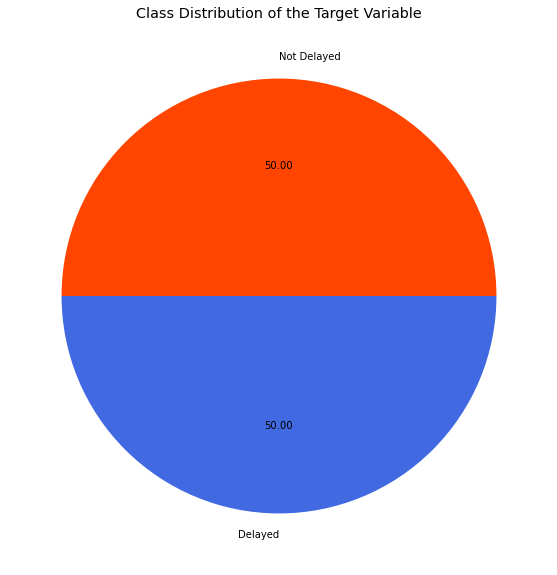

In [29]:
# Visualize the balanced class distribution
fig, ax = plt.subplots(figsize=(12, 10))
y_train_res.value_counts().plot.pie(autopct='%.2f', title='Class Distribution of the Target Variable', 
                                        labels=['Not Delayed', 'Delayed'], colors=['orangered', 'royalblue'])
ax.yaxis.set_visible(False);

As shown above, the undersampling method worked! To see just how much my training data has been reduced, I print the shape of the reshaped training data below. I see that the dataset now has 173,382 observations to train my model on, and that the features remained intact. This reduction in observations should make modeling easier within my computational constraints.

In [30]:
# Print the balanced training dataset's shape
X_train_res.shape

(173382, 139)

## Modeling

Now it's time to begin modeling! I will create a few baseline models, to start, then cross-validate 4 different classifiers, and evaluate them based on precision, recall, and f1 scores. As a reminder, my main focus is to improve precision, and consequently, the false positive count. The false positive count, in this case, represents the amount of on-time flights predicted as delays. This is crucial because if not addressed properly, the model could spread misinformation, and lead to passengers missing their on-time flights. This would lead to further consumer disapproval, and hurt the company's sales and reputation. However, I will still track the recall score (or the amount of false negatives), and the f1 score, which is the harmonic mean of precision and recall. The baseline model with the best trio of average metric scores will be selected to undergo hyperparameter tuning and further evaluation.

### Baseline Modeling:

I will begin by using `imblearn`'s `make_pipeline` function in order to pass a sampler along with a scaler and classifier into my pipeline(s). I cross-validate these pipelines in 3 folds, then take the average of each score and print them for each classifier. 

In [31]:
# Make two lists, one containing classifier names and the other containing the classifiers
classifier_names = ['Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting']
classifiers = [DecisionTreeClassifier(random_state=seed), RandomForestClassifier(random_state=seed), 
               AdaBoostClassifier(random_state=seed), GradientBoostingClassifier(random_state=seed)]

# Loop through the two lists to create a Pipeline, cross-validate the model, and print the relevant scores
for name, classifier in zip(classifier_names, classifiers):
    pipe = make_pipeline((RandomUnderSampler(sampling_strategy=1, random_state=seed)),
                          (MinMaxScaler()),
                          (classifier))
    score = cross_validate(pipe, X, y, cv=3, scoring=['precision', 'recall', 'f1'])
    model_scores = []
    keys = ['test_precision', 'test_recall', 'test_f1']
    for key in keys:
        model_scores.append(np.mean(score[key]))
    print("Test precision, recall and F1 scores for {}: {}\n".format(name, model_scores))

Test precision, recall and F1 scores for Decision Tree: [0.2036319709613683, 0.4754932502596054, 0.2811930503015776]

Test precision, recall and F1 scores for Random Forest: [0.24767570247321194, 0.5141658013153341, 0.3253398416456819]

Test precision, recall and F1 scores for AdaBoost: [0.24669017438739085, 0.5515057113187954, 0.3356349773479644]

Test precision, recall and F1 scores for Gradient Boosting: [0.24535113500312686, 0.5704395984769817, 0.3380784192923488]



Based on the precision scores listed above, it seems that the Random Forest, AdaBoost, and GradientBoosting Classifiers are better than Decision Trees, which eliminates that model from further iterating. It is tough to select which of the remaining three is "best" due to how close their precision scores are. Fortunately, I can use the other two scores (recall and f1) to help me narrow it down. Despite the Random Forest classifier having the highest precision score (approximately 0.248), it is the  GradientBoosting model that has the best **trio** of scores (0.245, 0.570, 0.338). The GradientBoosting Classifier's precision is slightly lower than the Random Forest's, but that 0.002 different seems negligible enough to select the former as the best baseline model, especially with the highest recall and f1 scores, as well. 

Unfortunately, 24.5% precision is still poor, and needs to be improved with some hyperparameter tuning. 

### Tuning the "Best" Baseline Model:

In order to keep in line with the business objectives, I need to set the `scoring` parameter to the three metrics I have been tracking so far. I will create a dictionary object that holds these three scores, and pass it into the `GridSearchCV` function. I will also pass a pipeline into the function, that will apply `MinMaxScaler`, `PCA`, and my chosen classifier over the folds (which in this case, is 3) from the exhaustive grid search process. My last step before fitting the grid search object is to create a parameter grid for the function to circulate through. I include parameters for my classifier, and for the `PCA` function, which is my attempt to reduce the dimensionality of my data. Once I've set all the relevant parameters, I fit the grid search object.

>Note: Depending on computational constraints, the code can take over **4 hours** to fully run!

In [32]:
# Create a dictionary of relevant scoring metrics
scorers = {'precision_score': make_scorer(precision_score), 
           'recall_score': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

# Create a Pipeline with a scaler and pca step
gbt_pipe = Pipeline(steps=[('scaler', MinMaxScaler()),
                           ('pca', PCA(random_state=seed)),
                           ('classifier', GradientBoostingClassifier(random_state=seed))])

# Create a parameter grid for the GradientBoosting Classifier
gbt_param_grid = {'pca__n_components': [5, 10, 25, 50],
                  'classifier__n_estimators': [50, 75, 100],
                  'classifier__learning_rate': [1, 0.1, 0.01]}

# Instantiate the GridSearchCV function with the 'refit' parameter set to 'precision_score'
gbt_gridsearch = GridSearchCV(gbt_pipe, gbt_param_grid, scoring=scorers,
                              refit='precision_score', verbose=3, cv=3)

In [33]:
# Fit the GridSearchCV object
gbt_gridsearch.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=5, f1_score=0.509, precision_score=0.542, recall_score=0.480, total=  18.3s
[CV] classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.2s remaining:    0.0s


[CV]  classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=5, f1_score=0.520, precision_score=0.545, recall_score=0.497, total=  19.4s
[CV] classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=5 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.7s remaining:    0.0s


[CV]  classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=5, f1_score=0.522, precision_score=0.548, recall_score=0.498, total=  18.7s
[CV] classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=10 
[CV]  classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=10, f1_score=0.530, precision_score=0.559, recall_score=0.504, total=  35.4s
[CV] classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=10 
[CV]  classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=10, f1_score=0.535, precision_score=0.562, recall_score=0.510, total=  33.1s
[CV] classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=10 
[CV]  classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=10, f1_score=0.541, precision_score=0.565, recall_score=0.519, total=  31.0s
[CV] classifier__learning_rate=1, classifier__n_estimators=50, pca__n_components=25 
[CV]  classifier__learnin

[CV]  classifier__learning_rate=0.1, classifier__n_estimators=50, pca__n_components=5, f1_score=0.517, precision_score=0.535, recall_score=0.501, total=  18.6s
[CV] classifier__learning_rate=0.1, classifier__n_estimators=50, pca__n_components=5 
[CV]  classifier__learning_rate=0.1, classifier__n_estimators=50, pca__n_components=5, f1_score=0.523, precision_score=0.543, recall_score=0.505, total=  17.2s
[CV] classifier__learning_rate=0.1, classifier__n_estimators=50, pca__n_components=5 
[CV]  classifier__learning_rate=0.1, classifier__n_estimators=50, pca__n_components=5, f1_score=0.517, precision_score=0.547, recall_score=0.490, total=  18.6s
[CV] classifier__learning_rate=0.1, classifier__n_estimators=50, pca__n_components=10 
[CV]  classifier__learning_rate=0.1, classifier__n_estimators=50, pca__n_components=10, f1_score=0.530, precision_score=0.552, recall_score=0.510, total=  31.5s
[CV] classifier__learning_rate=0.1, classifier__n_estimators=50, pca__n_components=10 
[CV]  classif

[CV]  classifier__learning_rate=0.1, classifier__n_estimators=100, pca__n_components=50, f1_score=0.639, precision_score=0.601, recall_score=0.683, total= 5.9min
[CV] classifier__learning_rate=0.1, classifier__n_estimators=100, pca__n_components=50 
[CV]  classifier__learning_rate=0.1, classifier__n_estimators=100, pca__n_components=50, f1_score=0.636, precision_score=0.605, recall_score=0.671, total= 5.9min
[CV] classifier__learning_rate=0.01, classifier__n_estimators=50, pca__n_components=5 
[CV]  classifier__learning_rate=0.01, classifier__n_estimators=50, pca__n_components=5, f1_score=0.502, precision_score=0.530, recall_score=0.476, total=  17.2s
[CV] classifier__learning_rate=0.01, classifier__n_estimators=50, pca__n_components=5 
[CV]  classifier__learning_rate=0.01, classifier__n_estimators=50, pca__n_components=5, f1_score=0.497, precision_score=0.528, recall_score=0.469, total=  17.1s
[CV] classifier__learning_rate=0.01, classifier__n_estimators=50, pca__n_components=5 
[CV] 

[CV]  classifier__learning_rate=0.01, classifier__n_estimators=100, pca__n_components=25, f1_score=0.579, precision_score=0.562, recall_score=0.596, total= 2.7min
[CV] classifier__learning_rate=0.01, classifier__n_estimators=100, pca__n_components=25 
[CV]  classifier__learning_rate=0.01, classifier__n_estimators=100, pca__n_components=25, f1_score=0.538, precision_score=0.583, recall_score=0.500, total= 2.7min
[CV] classifier__learning_rate=0.01, classifier__n_estimators=100, pca__n_components=50 
[CV]  classifier__learning_rate=0.01, classifier__n_estimators=100, pca__n_components=50, f1_score=0.637, precision_score=0.578, recall_score=0.711, total= 5.6min
[CV] classifier__learning_rate=0.01, classifier__n_estimators=100, pca__n_components=50 
[CV]  classifier__learning_rate=0.01, classifier__n_estimators=100, pca__n_components=50, f1_score=0.652, precision_score=0.571, recall_score=0.761, total= 5.6min
[CV] classifier__learning_rate=0.01, classifier__n_estimators=100, pca__n_compone

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 206.7min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('pca', PCA(random_state=24)),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=24))]),
             param_grid={'classifier__learning_rate': [1, 0.1, 0.01],
                         'classifier__n_estimators': [50, 75, 100],
                         'pca__n_components': [5, 10, 25, 50]},
             refit='precision_score',
             scoring={'f1_score': make_scorer(f1_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)},
             verbose=3)

Now that the grid search has fully run, I can use the `best_params_` and `best_score_` attributes to find just that - the best parameters found through my grid search and the best cross-validated score of the best estimator. I see that my grid search found 50 components for the `PCA` function; 75 estimators and a learning rate of 1 for the GradientBoosting classifier were best, and refit the model based on these hyperparameters. The best score (0.608) is pretty low, and tells me this model is not performing well. I plot the confusion matrix to get a better look into how well this model does.

In [34]:
# Print the 'best' parameters and the best score for the model
print('Best params for GradientBoostingClassifier refit for {}:'.format('precision_score'))
print(gbt_gridsearch.best_params_)
print('\n')
print('Best score for GradientBoostingClassifier refit for {}:'.format('precision_score'))
print(gbt_gridsearch.best_score_)

Best params for GradientBoostingClassifier refit for precision_score:
{'classifier__learning_rate': 1, 'classifier__n_estimators': 75, 'pca__n_components': 50}


Best score for GradientBoostingClassifier refit for precision_score:
0.60797649319375


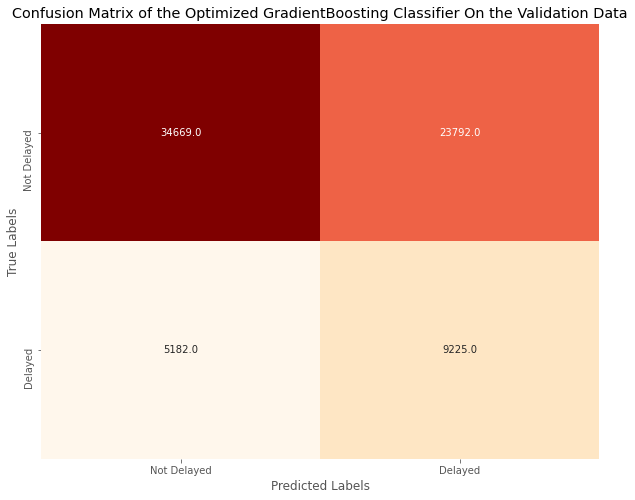

In [35]:
# Plot the confusion matrix
y_hat_val = gbt_gridsearch.predict(X_val)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_val, y_hat_val), annot=True,
           fmt='.1f', xticklabels=['Not Delayed', 'Delayed'],
           yticklabels=['Not Delayed', 'Delayed'], cmap='OrRd', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title('Confusion Matrix of the Optimized GradientBoosting Classifier On the Validation Data')
plt.show();

From initial observation, I can see this model needs more training, especially if my hope is to reduce the false positive count and improve my precision score. The false positive count is 23,792, which is pretty high even if it's just my baseline. I print the classification report below to get a full look into the grid search's metric scores, including recall and f1.

In [36]:
# Print the classification report
print(classification_report(y_val, y_hat_val))

              precision    recall  f1-score   support

           0       0.87      0.59      0.71     58461
           1       0.28      0.64      0.39     14407

    accuracy                           0.60     72868
   macro avg       0.57      0.62      0.55     72868
weighted avg       0.75      0.60      0.64     72868



I'll use the visual and scores above as my baseline to compare against the next step of my modeling phase: deep learning.

### Deep Learning:

Before I begin creating neural networks to train my data on, it's important I normalize the input datasets so that they are all on the same scale; otherwise, the models will generate flawed results. I will use `MinMaxScaler` once again, and transform all three input datasets, but only fitting on the training data.

In [39]:
# Use the MinMaxScaler function to scale the data
cols = X_train_res.columns

mmscaler = MinMaxScaler()
X_train_scaled = mmscaler.fit_transform(X_train_res)
X_val_scaled = mmscaler.transform(X_val)
X_test_scaled = mmscaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=cols)
X_val = pd.DataFrame(X_val_scaled, columns=cols)
X_test = pd.DataFrame(X_test_scaled, columns=cols)

# Check & reconfirm the training data's shape
X_train.shape

(173382, 139)

I see from the last line of code that the shape of the training data has remained intact, and that my data is ready to be modeled. To begin, I build a small baseline neural network - specifically, with 2 hidden layers and 1 output layer). I also set some regularization to help counter any potential overfitting. 

Seeing as how this is a classification problem, it's important I select loss and optimizer functions that work well in binary classification. From my knowledge, binary cross-entropy and Adam optimization work best in these situations, so I pass them along with a metrics parameter in the compiler function. The summary below shows the number of parameters that exist (and will be trained) in the network, which in this case is over 10,000 parameters!

In [40]:
# Create a small-layered baseline neural network
neural_network = Sequential()
neural_network.add(Dense(64, activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01), input_shape=(139, )))
neural_network.add(Dense(16, activation='relu'))
neural_network.add(Dense(1, activation='sigmoid'))

# Compile the baseline model
neural_network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# List a summary of the baseline model
neural_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                8960      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 10,017
Trainable params: 10,017
Non-trainable params: 0
_________________________________________________________________


I fit the baseline network to the training data, and run it for 32 epochs alongside the validation data.

In [41]:
# Fit the baseline model
baseline = neural_network.fit(X_train, y_train_res, epochs=32, batch_size=256,
                                      validation_data=(X_val, y_val))

Epoch 1/32
678/678 [==============================] - 3s 4ms/step - loss: 0.7355 - accuracy: 0.6001 - val_loss: 0.6686 - val_accuracy: 0.5720
Epoch 2/32
678/678 [==============================] - 2s 4ms/step - loss: 0.6576 - accuracy: 0.6146 - val_loss: 0.6546 - val_accuracy: 0.5929
Epoch 3/32
678/678 [==============================] - 3s 4ms/step - loss: 0.6550 - accuracy: 0.6175 - val_loss: 0.6319 - val_accuracy: 0.6352
Epoch 4/32
678/678 [==============================] - 3s 4ms/step - loss: 0.6533 - accuracy: 0.6213 - val_loss: 0.6702 - val_accuracy: 0.5799
Epoch 5/32
678/678 [==============================] - 3s 4ms/step - loss: 0.6518 - accuracy: 0.6237 - val_loss: 0.6625 - val_accuracy: 0.5889
Epoch 6/32
678/678 [==============================] - 2s 3ms/step - loss: 0.6505 - accuracy: 0.6259 - val_loss: 0.6425 - val_accuracy: 0.6241
Epoch 7/32
678/678 [==============================] - 2s 3ms/step - loss: 0.6493 - accuracy: 0.6291 - val_loss: 0.6688 - val_accuracy: 0.5837
Epoch 

Once all the epochs have been run through, I evaluate the network on both the training and validation data to get a look into the baseline networks accuracy and loss. Then I generate predictions and map the values to plot a confusion matrix, and get a further look into how the model performed. 

5419/5419 [==============================] - 6s 1ms/step - loss: 7.9649 - accuracy: 0.5000
Training data results:
[7.964900970458984, 0.5]


2278/2278 [==============================] - 2s 893us/step - loss: 0.6834 - accuracy: 0.5849
Validation data results:
[0.6833565831184387, 0.5848795175552368]


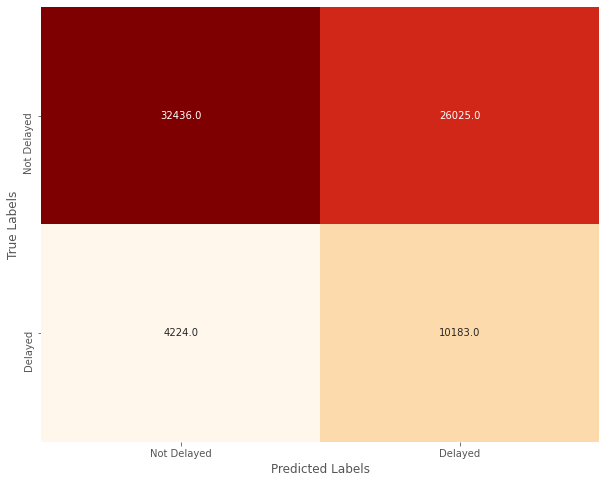

In [42]:
# Evaluate the loss and accuracy scores for the training and validation datasets
print(f'Training data results:\n{neural_network.evaluate(X_train_res, y_train_res)}')
print('\n')
print(f'Validation data results:\n{neural_network.evaluate(X_val, y_val)}')

# Generate predictions and "round" the values
baseline_preds = neural_network.predict(X_val)
baseline_preds[baseline_preds > 0.5] = 1
baseline_preds[baseline_preds < 0.5] = 0

# Plot a confusion matrix of the validation data
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_val, baseline_preds), annot=True,
           fmt='.1f', xticklabels=['Not Delayed', 'Delayed'],
           yticklabels=['Not Delayed', 'Delayed'], cmap='OrRd', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

I see above that both datasets have accuracies slightly greater than, or equal to, 50%. Although this is only a baseline model, that is still very poor performance. Fortunately, it doesn't look like there is any overfitting occuring on the training data, which could be due to the L2 regularizer I applied. The confusion matrix above further suggests the model performs poorly. When compared to the tuned GradientBoosting classifier, the model is worse considering the false positive count increased from 23,792 flights to 26,025 flights. That is unacceptable and goes against my objective. 

Below is the classification report for the baseline network to see how the model performed based on the three metrics I"ve been tracking thus far (precision, recall and f1 score). However, for simplicity's sake, I also create a function further below that will take in the expected and predicted labels, and generate the three scores.

In [43]:
# Print the classification report
print(classification_report(y_val, baseline_preds))

              precision    recall  f1-score   support

           0       0.88      0.55      0.68     58461
           1       0.28      0.71      0.40     14407

    accuracy                           0.58     72868
   macro avg       0.58      0.63      0.54     72868
weighted avg       0.77      0.58      0.63     72868



In [44]:
# Create a function that will calculate the three relevant scores to this analysis
def model_metrics(a, b):
    
    precision = precision_score(a, b)
    recall = recall_score(a, b)
    f1 = f1_score(a, b)

    print('Precision score:', round(precision * 100, 2),'%')
    print('Recall score:', round(recall * 100, 2),'%')
    print('F1 score:', round(f1 * 100, 2),'%')

# Run the function with both labels passed in
model_metrics(y_val, baseline_preds)

Precision score: 28.12 %
Recall score: 70.68 %
F1 score: 40.24 %


It seems the recall score is the only one to increase significantly, when compared to the GradientBoosting classifier. This means the models sensitivity, or ability to predict positive results, has increased. Despite this improvement, I am looking to also reduce the false positive count, which will require further modeling.

I will create another neural network; however, it will have 3 hidden layers, instead of two (and the units will be adjusted, accordingly). I apply the same compiler parameters, and print the summary again to see how many more parameters I am training. This denser network will train 11,313 total parameters.

In [45]:
# Create another, more dense neural network
neural_network2 = Sequential()
neural_network2.add(Dense(64, activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01), input_shape=(139, )))
neural_network2.add(Dense(32, activation='relu'))
neural_network2.add(Dense(8, activation='relu'))
neural_network2.add(Dense(1, activation='sigmoid'))

# Compile the baseline model
neural_network2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# List a summary of the baseline model
neural_network2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                8960      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 11,313
Trainable params: 11,313
Non-trainable params: 0
_________________________________________________________________


I fit the model this time to **50 epochs** in order to increase my training performance, and in the hope that my precision will increase as well. I will retain the batch size and evaluate on the validation data again.

In [46]:
# Fit the baseline model
results = neural_network2.fit(X_train, y_train_res, epochs=50, batch_size=256,
                                      validation_data=(X_val, y_val))

Epoch 1/50
678/678 [==============================] - 3s 5ms/step - loss: 0.7333 - accuracy: 0.6068 - val_loss: 0.6439 - val_accuracy: 0.6143
Epoch 2/50
678/678 [==============================] - 3s 4ms/step - loss: 0.6558 - accuracy: 0.6169 - val_loss: 0.6210 - val_accuracy: 0.6474
Epoch 3/50
678/678 [==============================] - 3s 4ms/step - loss: 0.6530 - accuracy: 0.6224 - val_loss: 0.6506 - val_accuracy: 0.6137
Epoch 4/50
678/678 [==============================] - 3s 4ms/step - loss: 0.6509 - accuracy: 0.6252 - val_loss: 0.6435 - val_accuracy: 0.6292
Epoch 5/50
678/678 [==============================] - 3s 4ms/step - loss: 0.6499 - accuracy: 0.6265 - val_loss: 0.6441 - val_accuracy: 0.6280
Epoch 6/50
678/678 [==============================] - 1s 2ms/step - loss: 0.6485 - accuracy: 0.6292 - val_loss: 0.6421 - val_accuracy: 0.6279
Epoch 7/50
678/678 [==============================] - 1s 2ms/step - loss: 0.6474 - accuracy: 0.6305 - val_loss: 0.6343 - val_accuracy: 0.6266
Epoch 

5419/5419 [==============================] - 6s 1ms/step - loss: 3.3523 - accuracy: 0.5326
Training data results:
[3.352281332015991, 0.5325697064399719]


2278/2278 [==============================] - 2s 1ms/step - loss: 0.6311 - accuracy: 0.6414
Validation data results:
[0.6310626864433289, 0.6413652300834656]


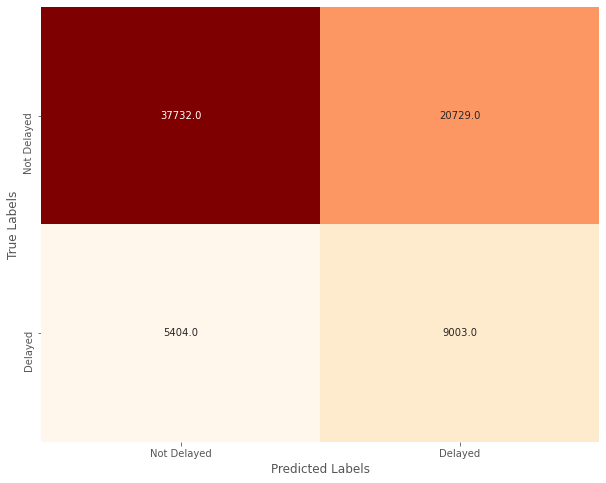

In [47]:
# Evaluate the loss and accuracy scores for the training and validation datasets
print(f'Training data results:\n{neural_network2.evaluate(X_train_res, y_train_res)}')
print('\n')
print(f'Validation data results:\n{neural_network2.evaluate(X_val, y_val)}')

# Generate predictions and "round" the values
y_preds2 = neural_network2.predict(X_val)
y_preds2[y_preds2 > 0.5] = 1
y_preds2[y_preds2 < 0.5] = 0

# Plot a confusion matrix of the validation data
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_val, y_preds2), annot=True,
           fmt='.1f', xticklabels=['Not Delayed', 'Delayed'],
           yticklabels=['Not Delayed', 'Delayed'], cmap='OrRd', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Based on the training and validation accuracies, I see that my model improved! Despite the fact that my validation accuracy is still low at 64.1%, the neural network's performance improved, which is also evident from the confusion matrix. My false positive count was reduced from 26,025 to 20,729, which is exactly what I aimed for, but is still not enough. Unfortunately, my true positive count decreased as well, which is a problem. I print out the three metrics once again to get a better idea of my model's performance.

In [48]:
# Run the metrics function
model_metrics(y_val, y_preds2)

Precision score: 30.28 %
Recall score: 62.49 %
F1 score: 40.79 %


I see that the three scores above correlate with what I deduced - the precision score increased to 30.3% and the recall score decreased to 62.5%, which is to be expected after seeing the false positive and true positive counts change, respectively. I will create one more neural network to try to improve my false positive count a little further. Below I create another network, reverting back to my baseline architecture.

In [49]:
# Create a neural network similar to the baseline
neural_network3 = Sequential()
neural_network3.add(Dense(64, activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01), input_shape=(139, )))
neural_network3.add(Dense(16, activation='relu'))
neural_network3.add(Dense(1, activation='sigmoid'))

# Compile the baseline model
neural_network3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# List a summary of the baseline model
neural_network3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                8960      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 10,017
Trainable params: 10,017
Non-trainable params: 0
_________________________________________________________________


This iteration will differ from the other two networks I built by increasing the epochs to 128, but I will also set a stopping condition with the `EarlyStopping` function, and save that checkpoint as my "best model" with the `ModelCheckpoint` function. I will pass this stopping condition as I fit my model, evaluating it once again on my validation data. 

In [50]:
# Create a file name object for the best model checkpoint
model_filepath = 'best_model.h5'

# Set early stopping and model checkpoint conditions
early_stopping = [EarlyStopping(monitor='val_loss', patience=6), 
                  ModelCheckpoint(filepath=model_filepath, monitor='val_loss', save_best_only=True)]

In [51]:
# Fit the baseline model with more epochs
results2 = neural_network3.fit(X_train, y_train_res, epochs=128, batch_size=256, callbacks=early_stopping,
                                      validation_data=(X_val, y_val))

Epoch 1/128
678/678 [==============================] - 3s 4ms/step - loss: 0.7359 - accuracy: 0.6040 - val_loss: 0.6519 - val_accuracy: 0.5974
Epoch 2/128
678/678 [==============================] - 2s 4ms/step - loss: 0.6573 - accuracy: 0.6142 - val_loss: 0.6599 - val_accuracy: 0.5961
Epoch 3/128
678/678 [==============================] - 2s 3ms/step - loss: 0.6550 - accuracy: 0.6188 - val_loss: 0.6552 - val_accuracy: 0.6011
Epoch 4/128
678/678 [==============================] - 2s 4ms/step - loss: 0.6528 - accuracy: 0.6217 - val_loss: 0.6144 - val_accuracy: 0.6543
Epoch 5/128
678/678 [==============================] - 3s 4ms/step - loss: 0.6507 - accuracy: 0.6247 - val_loss: 0.7023 - val_accuracy: 0.5416
Epoch 6/128
678/678 [==============================] - 3s 4ms/step - loss: 0.6497 - accuracy: 0.6277 - val_loss: 0.6338 - val_accuracy: 0.6379
Epoch 7/128
678/678 [==============================] - 2s 3ms/step - loss: 0.6488 - accuracy: 0.6295 - val_loss: 0.6706 - val_accuracy: 0.5802

I see that my model has stopped after 10 epochs! Now I will take that saved model, load it, and evaluate the model on the training and validation data to view its accuracy. I will also plot the confusion matrix, and see how the model performed. 

In [52]:
# Load the best (saved) model for the augmented data
saved_model = load_model(model_filepath)

# Calculate the loss and accuracy scores for both training datasets
results_train = saved_model.evaluate(X_train, y_train_res)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_val = saved_model.evaluate(X_val, y_val)
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

5419/5419 [==============================] - 6s 1ms/step - loss: 0.6511 - accuracy: 0.6269
Training Loss: 0.651 
Training Accuracy: 0.627
----------
2278/2278 [==============================] - 2s 1ms/step - loss: 0.6144 - accuracy: 0.6543
Validation Loss: 0.614 
Validation Accuracy: 0.654


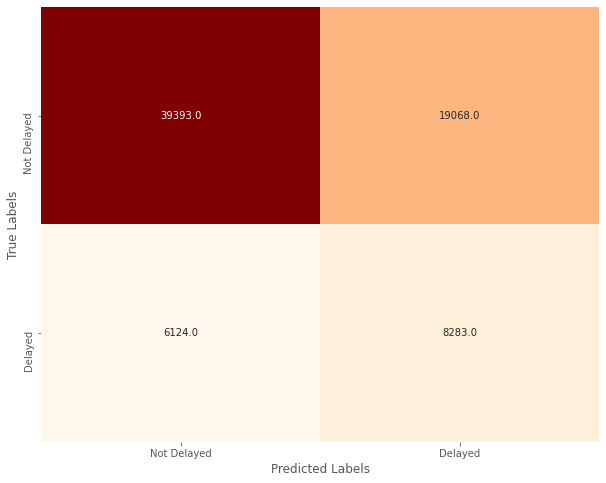

In [53]:
# Generate predictions and "round" the values
y_val_preds = saved_model.predict(X_val)
y_val_preds[y_val_preds > 0.5] = 1
y_val_preds[y_val_preds < 0.5] = 0

# Plot a confusion matrix of the validation data
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_val, y_val_preds), annot=True,
           fmt='.1f', xticklabels=['Not Delayed', 'Delayed'],
           yticklabels=['Not Delayed', 'Delayed'], cmap='OrRd', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

This model predicted the least amount of false positive cases! Although the other metrics leave something to be desired, I can at least see that my model is improving, especially in its precision. The false positive cases amount to 19,068, which makes this good enough to serve as my final model (which is luckily already saved). I will take another look at the metrics scores. I see that the model is 30.3% precise, has a recall of 57.5%, and its f1 score is at 39.7%. 

In [54]:
# Calculate the relevant metrics
model_metrics(y_val, y_val_preds)

Precision score: 30.28 %
Recall score: 57.49 %
F1 score: 39.67 %


## Evaluation


Now that I have my "best" model, I will see how it performs on my test data. I will generate the predictions, and print the three scores plus its accuracy to get a full idea of how efficient my model is. Fortunately, the model has been already saved and has been included in the repository as my means of deployment. 

In [55]:
# Evaluate the test data and list the relevant metrics
results_test = saved_model.evaluate(X_test, y_test)
y_hat_test = saved_model.predict(X_test)
y_hat_test[y_hat_test > 0.5] = 1
y_hat_test[y_hat_test < 0.5] = 0
print('Generated {} predictions'.format(len(y_hat_test)))
print(f'Testing Loss: {results_test[0]:.3} \nTesting Accuracy: {results_test[1]:.3}')
model_metrics(y_test, y_hat_test)

2278/2278 [==============================] - 2s 952us/step - loss: 0.6158 - accuracy: 0.6530
Generated 72867 predictions
Validation Loss: 0.616 
Validation Accuracy: 0.653
Precision score: 30.36 %
Recall score: 57.83 %
F1 score: 39.82 %


My model's metrics are a semblance to how it performed on my validation data - the model is 30.4% precise, has a recall of 57.8%, and an f1 score of 39.8%. The good news is my model is consistent, and doesn't generate results wildly different from what I expected. However, there's room for improvement.

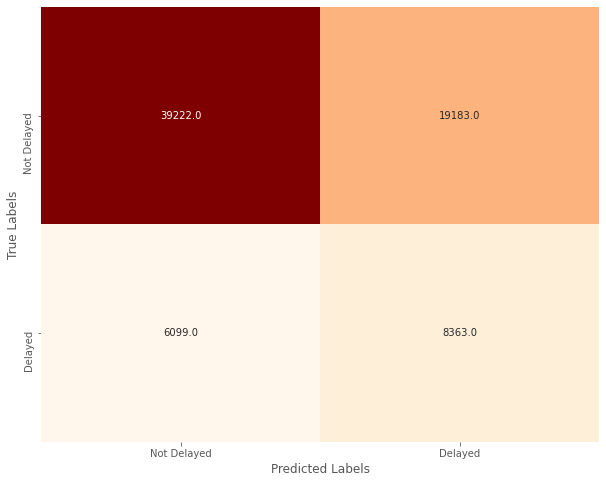

In [56]:
# Plot a confusion matrix of the test data
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_hat_test), annot=True,
           fmt='.1f', xticklabels=['Not Delayed', 'Delayed'],
           yticklabels=['Not Delayed', 'Delayed'], cmap='OrRd', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show();

The confusion matrix above shows similar results to the last plot - there are 19,183 false positive predictions, which is still better than the past models I built and evaluated. There is also slightly more true positive cases, which gives me some hope that the model can be improved to levels that are acceptable for mass deployment. 

## Conclusion

This analysis leads to the following conclusions:

1. The neural networks performed better than the machine learning algorithms I tested, and is the path I will explore further as I aim to improve my performance.

2. The model is 30.3% precise when testing and classifying flights as delayed or not delayed.

## Limitations/Further Work

This project is limited in a few ways. First and foremost, I built my models under heavy computational constraints. Given the nature of the data, it is necessary to train models on computers that can process large and full datasets in quicker time. For example, the grid search I performed earlier took four hours to run, which hinders me from further testing and modifications. Another drawback is the class imbalance. I applied sampling methods to reduce the majority class, which made training the model easier (less data), but also removed information that may have been necessary. Therefore, gathering more data that fall in the minority class would greatly improve my precision. Lastly, and this ties with my computational constraints, I could have used a wider range of hyperparameters to perform my grid search with. Unfortunately, with limited resources, it would have taken me hours or even days to fully perform this search. However, if I had, I could have found a better set of hyperparameters that would drive up my precision.

Further analyses could yield a more effective predictor, and possibly improve the algorithm's performance. Some possible courses of action I could take include:

1. Training my model with better, stronger computer(s).
2. Gathering more data with an emphasis on balancing the minority class to avoid sampling. 
3. Reducing the dimensions of my data to focus on solely weather or departing airports, in order to gain a more informative look at how certain features affect my predictions and precision. 

## Sources
Link to original dataset: 
https://www.kaggle.com/datasets/threnjen/2019-airline-delays-and-cancellations/data?select=full_data_flightdelay.csv

Wall Street Journal annual airlines ranking report:
https://www.wsj.com/lifestyle/travel/best-airlines-us-2023-36e9ea20

Bureau of Transportation Statistics:
https://www.transtats.bts.gov/HomeDrillChart.asp

Federal Aviation Administration (FAA):
https://aspm.faa.gov/aspmhelp/index/Types_of_Delay.html